## Password Strength Classifier

Dataset Source: https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.23.5
        Pandas: 2.0.0
      Datasets: 2.11.0
  Transformers: 4.27.4
         Torch: 2.0.0
      Evaluate: 0.4.0


#### Load & Start Preprocessing Dataset

In [3]:
data = pd.read_csv("data.csv", 
                   engine='c',
                   on_bad_lines='skip')

data

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1
...,...,...
669635,10redtux10,1
669636,infrared1,1
669637,184520socram,1
669638,marken22a,1


#### Define Dictionaries to Convert Between String & Integer Class Values

In [4]:
unique_classes = [
    "weak", 
    "medium", 
    "strong"
    ]

id2label = {idx:label for idx, label in enumerate(unique_classes)}
label2id = {label:idx for idx, label in enumerate(unique_classes)}
NUM_OF_LABELS = len(unique_classes)

#### Visual: Histogram of Password Lengths

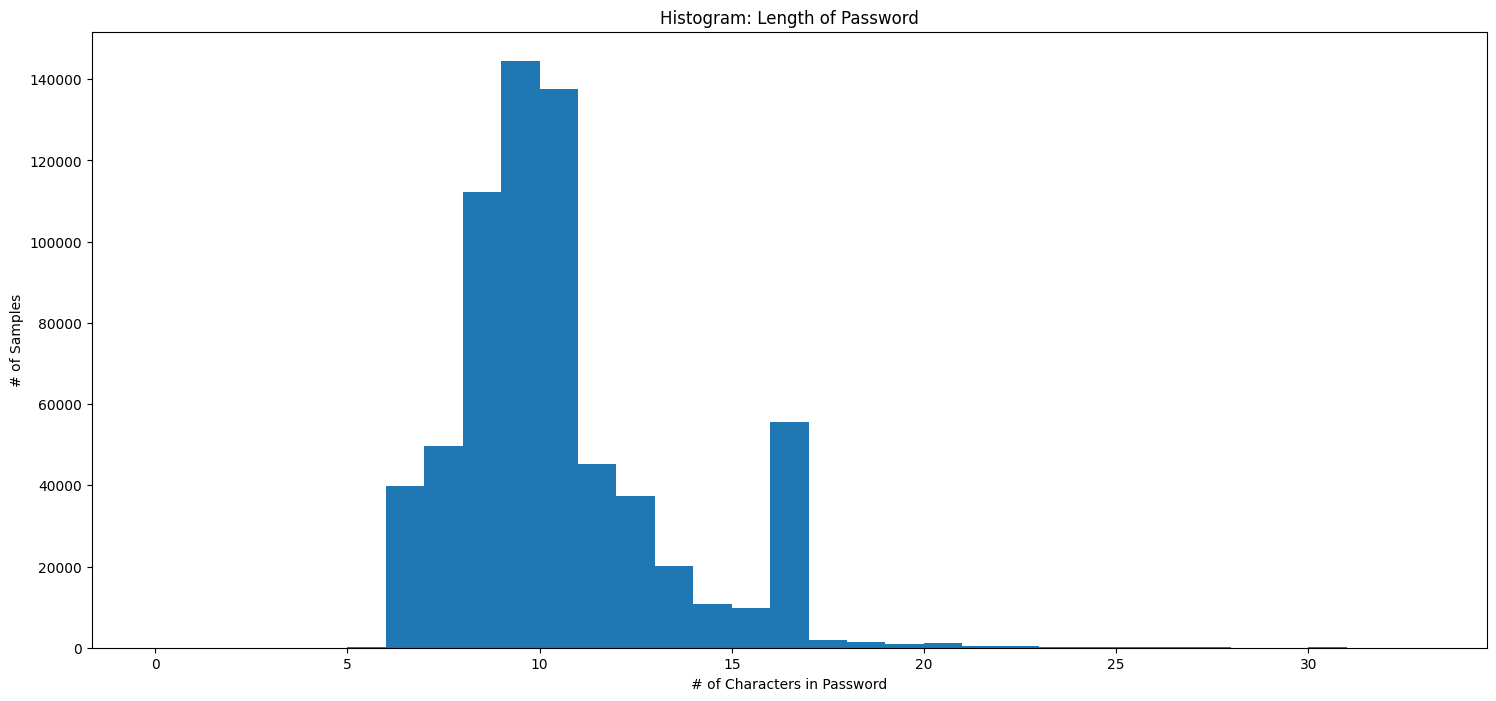

The maximum length of passwords is 220.0 characters.


In [5]:
data['text_length'] = data['password'].str.len()

n_bin=32
data.hist('text_length', 
          grid=False, 
          figsize=(18,8), 
          range=(0,n_bin + 1), 
          bins=n_bin + 1)
plt.title('Histogram: Length of Password')
plt.xlabel('# of Characters in Password')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of passwords is {max(data['text_length'])} characters.")

#### Visual: Password Length by Class

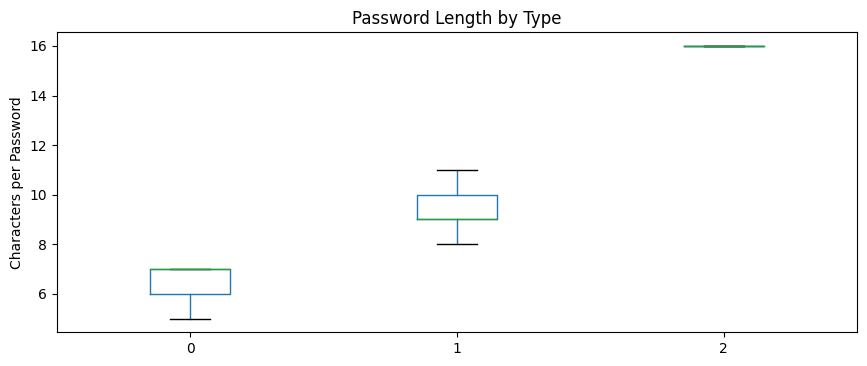

In [6]:
data.boxplot("text_length", 
             by="strength", 
             grid=False, 
             showfliers=False, 
             figsize=(10,4))

plt.suptitle('')
plt.title('Password Length by Type')
plt.xlabel('')
plt.ylabel('Characters per Password')
plt.show()

#### Remove Overly Length Samples

In [7]:
data = data[data["text_length"] < 32]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669607 entries, 0 to 669639
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   password     669607 non-null  object 
 1   strength     669607 non-null  int64  
 2   text_length  669607 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.4+ MB


#### Class Distribution

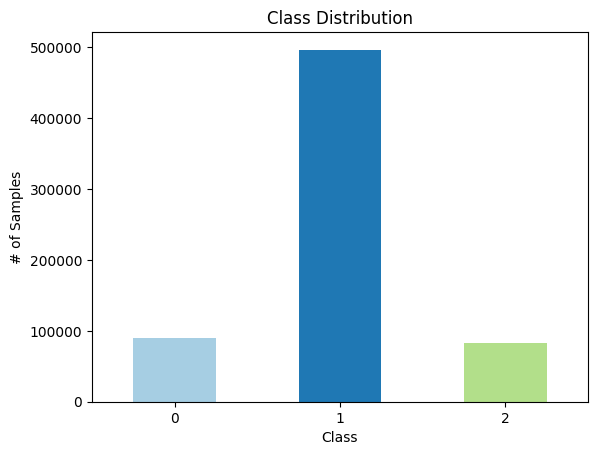

In [8]:
class_counts = data.groupby("strength").count()

class_counts['text_length'].plot.bar(label='strength', 
                                     color=plt.cm.Paired(np.arange(len(data))))
plt.suptitle('')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('# of Samples')
plt.xticks(rotation = 0)
plt.show()

#### Final Data Preprocessing & Convert DataFrame to Dataset

In [9]:
data = data.drop(columns=["text_length"])

data = data.rename(columns={"password": "text",
                            "strength": "label"})

dataset = Dataset.from_pandas(data)

#### Find Longest Tokenized Input Value

In [10]:
MODEL_CKPT = "microsoft/codebert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True,
                                             batched=True, 
                                             batch_size=None)

text_len = [len(tokenizer.encode(a)) for a in dataset["text"]]

print(f"The longest article length is {max(text_len)} tokens.")

The longest article length is 29 tokens.


#### Split Dataset into Training & Evaluation Datasets

In [11]:
train_eval = dataset.train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (535685, 3)
Evaluation Dataset Shape: (133922, 3)


#### Basic Values/Constants

In [12]:
set_seed = 42
NUM_OF_EPOCHS = 3

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = 30
MODEL_CKPT = "microsoft/codebert-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Password_Strength_Classifier"

METRIC_NAME = "f1"
DEVICE = torch.device("cpu")

print(f"This project will utilize the {str(DEVICE).upper()} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will utilize the CPU to train and evaluate.
This project will have a maximum length for the input text of 30 tokens.
The model checkpoint used for this project is: microsoft/codebert-base


#### Tokenize Entire Dataset

In [13]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, 
                     truncation=True, 
                     max_length=MAX_LENGTH, 
                     return_tensors="pt")

# Map tokenizer method to entire dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('Training data shape:', encoded_data['train'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

Map:   0%|          | 0/535685 [00:00<?, ? examples/s]

Map:   0%|          | 0/133922 [00:00<?, ? examples/s]

Training data shape: (535685, 5)
Validation data shape: (133922, 5)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 535685
})


#### Instantiate Model

In [14]:
model = (
    AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=NUM_OF_LABELS
    ).to(DEVICE))

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be 

#### Define Function to Compute Metrics

In [15]:
def compute_metrics(p):
    """
    This function takes the predictions output from 
    trainer.evaluate & returns metrics (accuracy, F1, 
    recall, & precision) for a multiclass 
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, 
                                                             axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                      axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]
    
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']
    
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                                  axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]
    
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]
    
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                        axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
    
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]
    
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [16]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=0.01,
    log_level="error",
    logging_strategy='epoch', 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [17]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [18]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [19]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/codebert-base-Password_Strength_Classifier into local empty directory.


#### Train Model

In [20]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/25113 [00:00<?, ?it/s]

{'loss': 1.1098, 'learning_rate': 1.9999203599729225e-05, 'epoch': 0.0}
{'loss': 0.0438, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/2093 [00:00<?, ?it/s]

{'eval_loss': 0.011203642003238201, 'eval_accuracy': 0.9955795164349397, 'eval_Weighted F1': 0.9955981682214771, 'eval_Micro F1': 0.9955795164349397, 'eval_Macro F1': 0.9935141612116123, 'eval_Weighted Recall': 0.9955795164349397, 'eval_Micro Recall': 0.9955795164349397, 'eval_Macro Recall': 0.9963461893460771, 'eval_Weighted Precision': 0.9956511554693804, 'eval_Micro Precision': 0.9955795164349397, 'eval_Macro Precision': 0.9907572834685863, 'eval_runtime': 4218.6885, 'eval_samples_per_second': 31.745, 'eval_steps_per_second': 0.496, 'epoch': 1.0}
{'loss': 0.0133, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/2093 [00:00<?, ?it/s]

{'eval_loss': 0.009153525345027447, 'eval_accuracy': 0.9966473021609593, 'eval_Weighted F1': 0.9966547367208318, 'eval_Micro F1': 0.9966473021609593, 'eval_Macro F1': 0.9950606828761922, 'eval_Weighted Recall': 0.9966473021609593, 'eval_Micro Recall': 0.9966473021609593, 'eval_Macro Recall': 0.9966331855184408, 'eval_Weighted Precision': 0.9966719846981876, 'eval_Micro Precision': 0.9966473021609593, 'eval_Macro Precision': 0.9935094748560319, 'eval_runtime': 4146.8808, 'eval_samples_per_second': 32.295, 'eval_steps_per_second': 0.505, 'epoch': 2.0}
{'loss': 0.0067, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/2093 [00:00<?, ?it/s]

{'eval_loss': 0.007663697935640812, 'eval_accuracy': 0.9974686757963591, 'eval_Weighted F1': 0.9974744654630983, 'eval_Micro F1': 0.9974686757963591, 'eval_Macro F1': 0.9962698425655323, 'eval_Weighted Recall': 0.9974686757963591, 'eval_Micro Recall': 0.9974686757963591, 'eval_Macro Recall': 0.9978107425679793, 'eval_Weighted Precision': 0.9974905219201232, 'eval_Micro Precision': 0.9974686757963591, 'eval_Macro Precision': 0.9947514976785458, 'eval_runtime': 4612.4931, 'eval_samples_per_second': 29.035, 'eval_steps_per_second': 0.454, 'epoch': 3.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'train_runtime': 180269.7266, 'train_samples_per_second': 8.915, 'train_steps_per_second': 0.139, 'train_loss': 0.021318447113758642, 'epoch': 3.0}


#### Save Model & Metrics on Training Dataset

In [21]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/476M [00:00<?, ?B/s]

Upload file runs/May05_23-17-50_Brians-Mac-mini/events.out.tfevents.1683346676.Brians-Mac-mini.15857.0:   0%| …

To https://huggingface.co/DunnBC22/codebert-base-Password_Strength_Classifier
   a23e958..4d7988c  main -> main

To https://huggingface.co/DunnBC22/codebert-base-Password_Strength_Classifier
   4d7988c..2fd5322  main -> main



***** train metrics *****
  epoch                    =                3.0
  train_loss               =             0.0213
  train_runtime            = 2 days, 2:04:29.72
  train_samples_per_second =              8.915
  train_steps_per_second   =              0.139


#### Evaluate Model

In [22]:
metrics = trainer.evaluate(encoded_data['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/2093 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_Macro F1           =     0.9963
  eval_Macro Precision    =     0.9948
  eval_Macro Recall       =     0.9978
  eval_Micro F1           =     0.9975
  eval_Micro Precision    =     0.9975
  eval_Micro Recall       =     0.9975
  eval_Weighted F1        =     0.9975
  eval_Weighted Precision =     0.9975
  eval_Weighted Recall    =     0.9975
  eval_accuracy           =     0.9975
  eval_loss               =     0.0077
  eval_runtime            = 1:08:32.33
  eval_samples_per_second =     32.566
  eval_steps_per_second   =      0.509


#### Push Model to HuggingFace Hub

In [23]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Upload file runs/May05_23-17-50_Brians-Mac-mini/events.out.tfevents.1683531779.Brians-Mac-mini.local.15857.2: …

To https://huggingface.co/DunnBC22/codebert-base-Password_Strength_Classifier
   2fd5322..93af2de  main -> main



'https://huggingface.co/DunnBC22/codebert-base-Password_Strength_Classifier/commit/93af2de6ecca8ac03378cbae0e56f8688f1c2812'

### Notes & Other Takeaways From This Project
****
- I should have created a visual for the classes (weak, medium, and strong) based on if certain special characters were or were not in the passwords.
- Although one epoch could have been enough training to fine-tune this project, I am glad that I trained it for 3 epochs.
****

### Citations
- Model Checkpoint
    > @misc{feng2020codebert, title={CodeBERT: A Pre-Trained Model for Programming and Natural Languages}, author={Zhangyin Feng and Daya Guo and Duyu Tang and Nan Duan and Xiaocheng Feng and Ming Gong and Linjun Shou and Bing Qin and Ting Liu and Daxin Jiang and Ming Zhou}, year={2020}, eprint={2002.08155}, archivePrefix={arXiv}, primaryClass={cs.CL}}

